## Prior parameters

In [23]:
from scipy.stats import gamma
from scipy.optimize import minimize
import numpy as np

rate_cov_interval = (0.1, 0.5)

def params_to_loc_scale(params):
    alpha, beta = params
    return dict(a=alpha, scale=1/beta)

def cov_to_precision(cov):
    return 1.0/np.log(np.array(cov[::-1])**2.0+1)

def precision_to_cov(precision):# \sqrt(e^(\sigma^2)-1)
    return (np.exp(1.0/precision)-1) ** 0.5

def params_to_quantiles(params, quantiles=(0.025, 0.975)):
    return gamma.ppf(quantiles, **params_to_loc_scale(params))

def diff(x, y):
    return np.linalg.norm(np.array(x) - y)

def obj(params, precision):
    return diff(params_to_quantiles(params), precision)

positive_bound = (0, None)
precision = cov_to_precision(rate_cov_interval)
res = minimize(obj, (1, 1), args=(precision,), bounds=[positive_bound, positive_bound], method="SLSQP")
res, precision_to_cov(gamma.pdf((0.025, 0.975), **params_to_loc_scale(res.x)))

/home/christiaanjs/miniconda3/envs/libsbn/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in double_scalars
  if __name__ == '__main__':
/home/christiaanjs/miniconda3/envs/libsbn/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:2003: RuntimeWarning: invalid value encountered in multiply
  lower_bound = _a * scale + loc
/home/christiaanjs/miniconda3/envs/libsbn/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: overflow encountered in exp
  from ipykernel import kernelapp as app


(     fun: 5.3157424472900134e-05
      jac: array([   20.59278571, -1047.89180187])
  message: 'Optimization terminated successfully.'
     nfev: 241
      nit: 49
     njev: 45
   status: 0
  success: True
        x: array([2.02640115, 0.05589465]),
 array([           inf, 1.66354093e+82]))

In [21]:
res.x

array([2.02640115, 0.05589465])

In [4]:
help(gamma)

Help on gamma_gen in module scipy.stats._continuous_distns object:

class gamma_gen(scipy.stats._distn_infrastructure.rv_continuous)
 |  gamma_gen(momtype=1, a=None, b=None, xtol=1e-14, badvalue=None, name=None, longname=None, shapes=None, extradoc=None, seed=None)
 |  
 |  A gamma continuous random variable.
 |  
 |  %(before_notes)s
 |  
 |  See Also
 |  --------
 |  erlang, expon
 |  
 |  Notes
 |  -----
 |  The probability density function for `gamma` is:
 |  
 |  .. math::
 |  
 |      f(x, a) = \frac{x^{a-1} \exp(-x)}{\Gamma(a)}
 |  
 |  for :math:`x \ge 0`, :math:`a > 0`. Here :math:`\Gamma(a)` refers to the
 |  gamma function.
 |  
 |  `gamma` takes ``a`` as a shape parameter for :math:`a`.
 |  
 |  When :math:`a` is an integer, `gamma` reduces to the Erlang
 |  distribution, and when :math:`a=1` to the exponential distribution.
 |  
 |  %(after_notes)s
 |  
 |  %(example)s
 |  
 |  Method resolution order:
 |      gamma_gen
 |      scipy.stats._distn_infrastructure.rv_continuo

## Model definition / data simulation

In [1]:
import tensorflow as tf
import tensorflow_probability as tfp

model_dict = dict(
    x = tfp.distributions.LogNormal(0, 1),
    y = tfp.distributions.LogNormal(0, 1),
    z = lambda x,y: tfp.distributions.Sample(tfp.distributions.Normal(x * y, 1), 10)
)
model = tfp.distributions.JointDistributionNamed(model_dict)
model_sample = model.sample()
data = model_sample['z']
model_sample

{'y': <tf.Tensor: shape=(), dtype=float32, numpy=1.1961483>,
 'x': <tf.Tensor: shape=(), dtype=float32, numpy=1.6269917>,
 'z': <tf.Tensor: shape=(10,), dtype=float32, numpy=
 array([0.9863924 , 1.5957762 , 1.2199507 , 2.4327765 , 4.0925713 ,
        0.87560403, 1.6931056 , 3.1872816 , 1.1813765 , 3.9909182 ],
       dtype=float32)>}

In [2]:
log_posterior = lambda x, y: model.log_prob(x=x, y=y, z=data)

## HMC inference

<tf.Tensor: shape=(3,), dtype=float32, numpy=array([0.7835, 0.7485, 0.755 ], dtype=float32)>

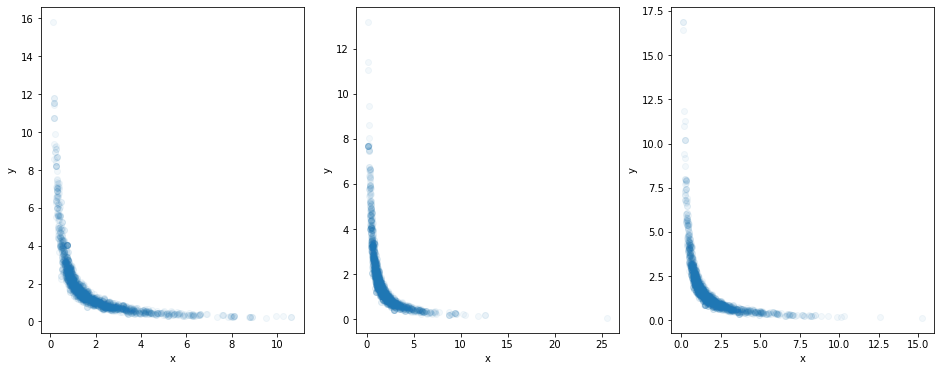

In [3]:
import matplotlib.pyplot as plt

@tf.function
def sample_posterior(num_chains=3, num_results=2000, num_burnin_steps=1000):
    hmc = tfp.mcmc.HamiltonianMonteCarlo(target_log_prob_fn=log_posterior, num_leapfrog_steps=10, step_size=1.0)
    unconstraining_bijectors = [tfp.bijectors.Exp(), tfp.bijectors.Exp()]
    transformed_kernel = tfp.mcmc.TransformedTransitionKernel(hmc, unconstraining_bijectors)
    kernel = tfp.mcmc.SimpleStepSizeAdaptation(transformed_kernel, int(num_burnin_steps*0.8))
    model_sample = model.sample(num_chains)
    init = [model_sample['x'], model_sample['y']]
    samples, acceptances = tfp.mcmc.sample_chain(num_results, init,
                                                    kernel=kernel, num_burnin_steps=num_burnin_steps,
                                                    trace_fn=lambda s, k: k.inner_results.inner_results.is_accepted
                                                   )
    acceptance_probs = tf.reduce_mean(tf.cast(acceptances, tf.float32), axis=0)
    return samples, acceptance_probs

num_chains = 3
samples, acceptance_probs = sample_posterior(num_chains=num_chains)
fig, axs = plt.subplots(ncols=num_chains, figsize=(16, 6))
for i, ax in enumerate(axs):
    ax.scatter(*[x[:, i] for x in samples], alpha=0.05)
    ax.set_xlabel('x')
    ax.set_ylabel('y')
acceptance_probs

## Mean field variational inference

In [4]:
import treeflow.model

q = tfp.distributions.JointDistributionNamed(dict(
    x = treeflow.model.construct_distribution_approximation('q', 'x', model_dict['x']),
    y =treeflow.model.construct_distribution_approximation('q', 'x', model_dict['y'])
))
log_posterior(**q.sample())

<tf.Tensor: shape=(), dtype=float32, numpy=-31.883978>

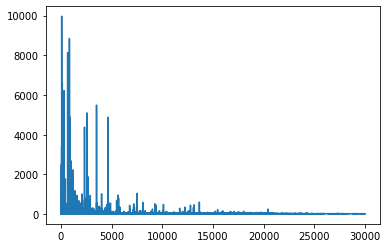

In [5]:
n_variational_steps = 30000
loss = tfp.vi.fit_surrogate_posterior(log_posterior, q, tf.optimizers.Adam(), n_variational_steps)
plt.plot(loss)

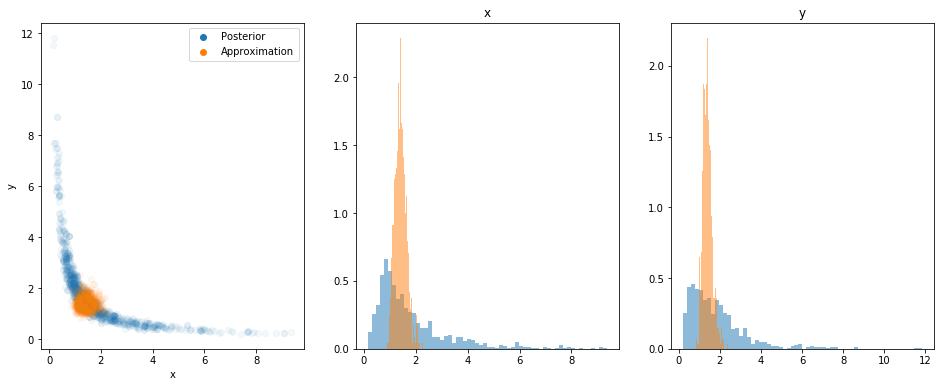

In [6]:
import numpy as np

var_order = { 'x': 0, 'y': 1 }

def plot_approximation(approximation, n_plot_samples=1000):
    fig, axs = plt.subplots(ncols=3, figsize=(16, 6))
    
    flat_samples = [x.numpy().flatten() for x in samples]
    sample_indices = np.random.choice(flat_samples[0].shape[0], size=n_plot_samples)
    mcmc_plot_samples = [x[sample_indices] for x in flat_samples]
    q_samples = approximation.sample(n_plot_samples)
    axs[0].scatter(*mcmc_plot_samples, alpha=0.05, label='Posterior')
    axs[0].scatter(q_samples['x'], q_samples['y'], alpha=0.05, label='Approximation')
    
    axs[0].set_xlabel('x')
    axs[0].set_ylabel('y')
    
    leg = axs[0].legend()
    for lh in leg.legendHandles: 
        lh.set_alpha(1)
        
    def plot_marginal(ax, var):
        ax.set_title(var)
        ax.hist(mcmc_plot_samples[var_order[var]], label='Posterior', alpha=0.5, density=True, bins=60)
        ax.hist(q_samples[var], label='Approximation', alpha=0.5, density=True, bins=60)
        
    plot_marginal(axs[1], 'x')
    plot_marginal(axs[2], 'y')
        
plot_approximation(q)

## Product approximation

Instructions for updating:
`batch_shape` and `event_shape` args are deprecated. Please use `tfd.Sample`, `tfd.Independent`, and broadcasted parameters of the base distribution instead. For example, replace `tfd.TransformedDistribution(tfd.Normal(0., 1.), tfb.Exp(), batch_shape=[2, 3], event_shape=[4])` with `tfd.TransformedDistrbution(tfd.Sample(tfd.Normal(tf.zeros([2, 3]), 1.),sample_shape=[4]), tfb.Exp())` or `tfd.TransformedDistribution(tfd.Independent(tfd.Normal(tf.zeros([2, 3, 4]), 1.), reinterpreted_batch_ndims=1), tfb.Exp())`.


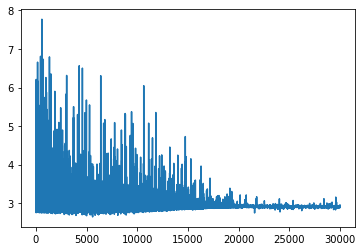

In [7]:
def build_product_approximation(base_dist, scale):
    bij = tfp.bijectors.Scale(1.0 / scale)
    return tfp.distributions.TransformedDistribution(base_dist, bij, batch_shape=scale.shape)

y_base_dist = treeflow.model.construct_distribution_approximation('q_structured', 'y', model_dict['y'])

q_structured = tfp.distributions.JointDistributionNamed(dict(
    x = treeflow.model.construct_distribution_approximation('q_structured', 'x', model_dict['x']),
    y = lambda x: build_product_approximation(y_base_dist, x)
))
trainable_variables = q_structured.trainable_variables
loss = tfp.vi.fit_surrogate_posterior(log_posterior, q_structured, tf.optimizers.Adam(), n_variational_steps, trainable_variables=trainable_variables)
plt.plot(np.log(loss))

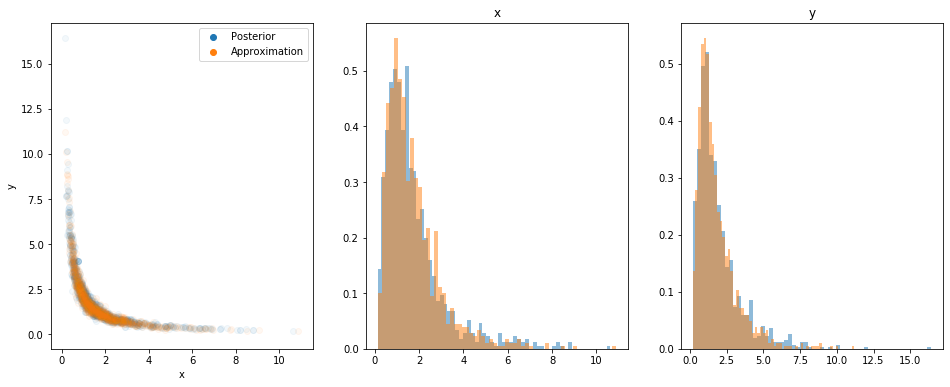

In [8]:
plot_approximation(q_structured)